In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/lm/_0dxbsxn12x_gj203f_bq6br0000gn/T/ipykernel_23617/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


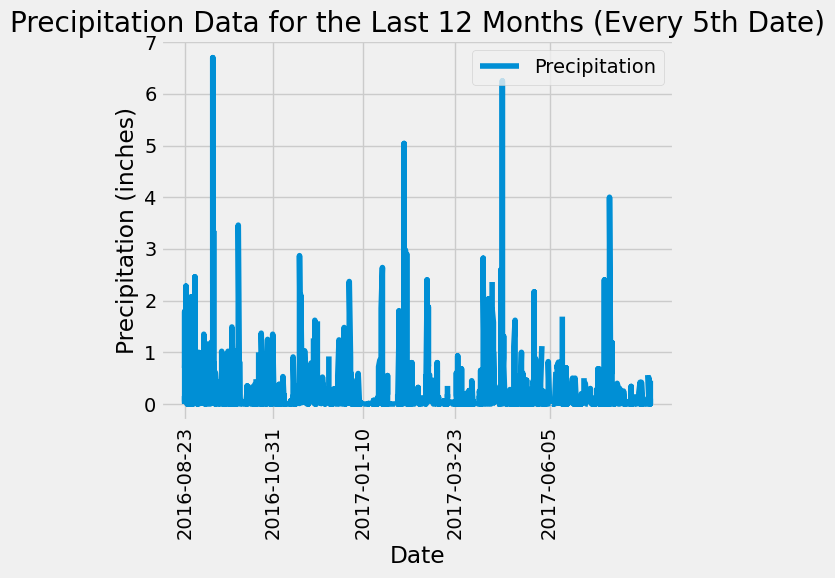

In [16]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results.
#Starting from the most recent data point in the database.
#Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

#Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago_str)\
    .order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


#Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')


#Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')

#Select every nth date
n = len(precipitation_df) // 5
selected_dates = precipitation_df.iloc[::n, 0]

plt.xticks(selected_dates, rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months (Every 5th Date)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
# List the stations and their counts in descending order.
print("Most active stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station).all()

# Print the results
print("Temperature statistics for the most active station:")
print("Lowest Temperature:", temperature_stats[0][0])
print("Highest Temperature:", temperature_stats[0][1])
print("Average Temperature:", round(temperature_stats[0][2], 2))

Temperature statistics for the most active station:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


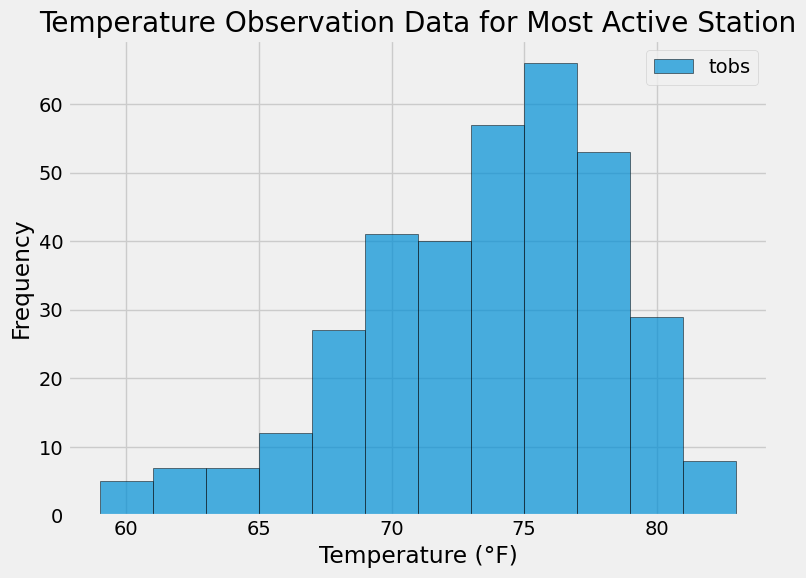

In [31]:
from matplotlib import pyplot as plt
# Using the most active station id
# Query to retrieve the last 12 months of temperature observation data for the most active station
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= one_year_ago_str).all()

# Convert the query result to a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Most Active Station')
plt.legend(['tobs'], loc='upper right')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()